# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [68]:
# Load pickled data
import pickle
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
import cv2
import numpy as np
import tensorflow as tf
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from numpy import zeros, newaxis
%matplotlib inline

# TODO: fill this in based on where you saved the training and testing data
training_file = "./train.p"
testing_file = "./test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [69]:
### Replace each question mark with the appropriate value.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

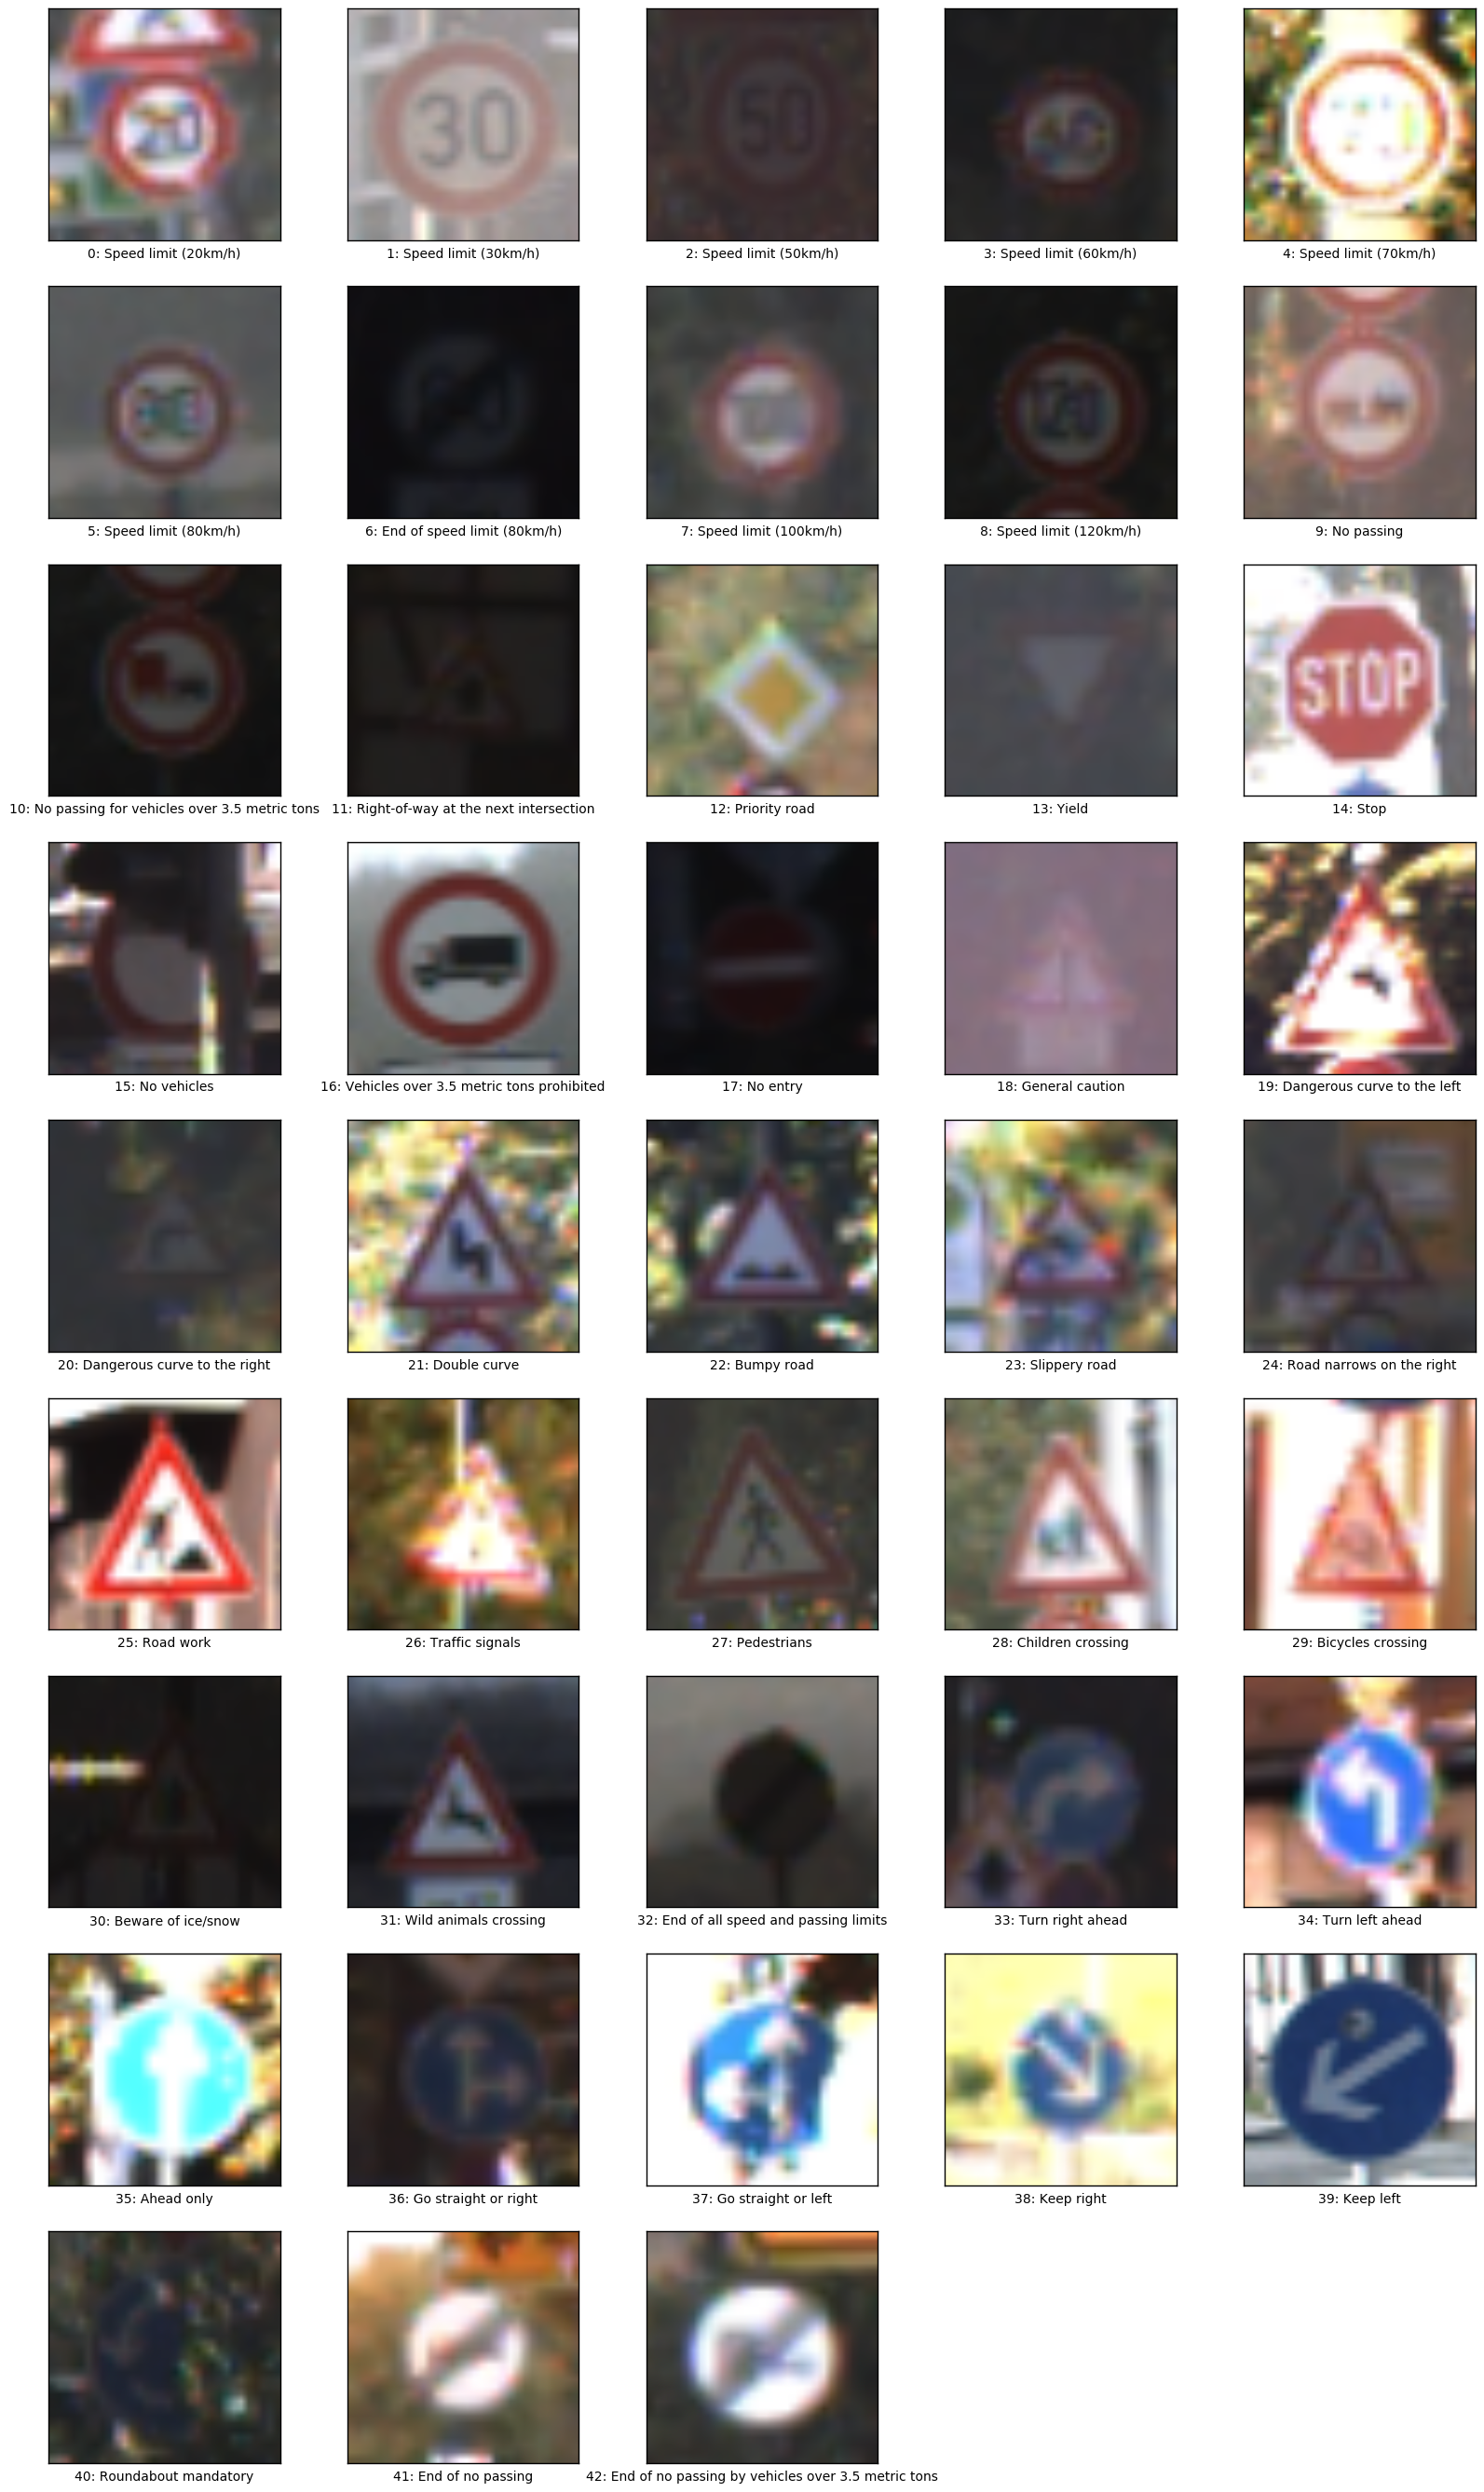

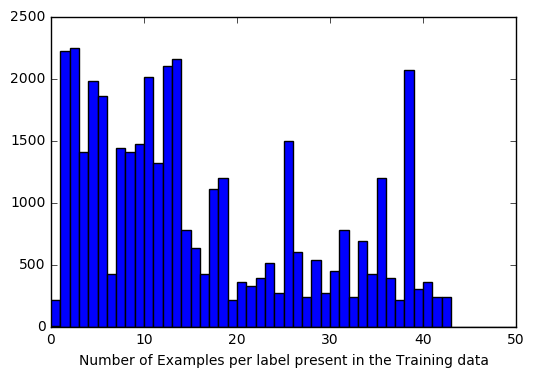

In [70]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline
import csv

fig2 = plt.figure(figsize = (20,34))

list_labels = []

m = 0
with open('./signnames.csv') as csvfile:
    reader = csv.DictReader(csvfile,  delimiter = ",")
    for y, x in zip(y_train, X_train):
        if not(y in list_labels):
            list_labels.append(y)
            im = fig2.add_subplot(9,5,(m+1))
            im.imshow(x)
            for row in reader:
                if (int(row['ClassId']) == y):
                    im.set_xlabel("{0}: {1}".format(row['ClassId'], row['SignName']))
                    break
            
            m += 1
            im.set_xticks([])
            im.set_yticks([])


plt.show()
plt.hist(y_train, bins=50, range=[0,50]);
plt.xlabel("Number of Examples per label present in the Training data")


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [71]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

def normalize(image_data):
    
    return (image_data/255 - 0.5)
    

In [72]:
def rgb2gray(image_data):
    
    image = np.mean(image_data, axis = 2)
    image = image[:,:, newaxis]
    
    return image

In [73]:
def hot_encoded(train):
    encoder = LabelBinarizer()
    encoder.fit(train)
    hot_encoded_labels = encoder.transform(train)

    hot_encoded_labels = hot_encoded_labels.astype(np.float32)
    
    return hot_encoded_labels

In [74]:
### Prepocessing the whole data including one-hot-encoding the labels

#train_data = X_train
#test_data = X_test

train_data = normalize(X_train)
test_data = normalize(X_test)

""""
train_data_gray = np.zeros(shape = (len(train_data),32,32,1))
test_data_gray = np.zeros(shape = (len(test_data),32,32,1))

for i in range(len(train_data)):
    train_data_gray[i] = rgb2gray(train_data[i])
for j in range(len(test_data)):
    test_data_gray[j] = rgb2gray(test_data[j])
train_data = train_data_gray
test_data = test_data_gray
del train_data_gray, test_data_gray
"""
train_labels = hot_encoded(y_train)
test_labels = hot_encoded(y_test)

train_data, train_labels = shuffle(train_data, train_labels)

print("Training data and Testing data are normalised")
print ("Train and Test labels are one-hot-encoded")


Training data and Testing data are normalised
Train and Test labels are one-hot-encoded


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** 

1. The train date is normalized to -0.5 - 0.5. if the data is unnormalised, the training will be difficult, as the optimizer does not point towards the minimum. As a result it takes more epochs to attain the global minimum. Also there is a risk of stucking in local minimum. As the weights starts from 0 mean, less number of epoch will suffice to attain the global minimum, if the data is normalized.
2. Also the train labels are One-hot-encoded to get the one - one mapping from softmax probabilities


    Un-normalized Epochs (Large fluctuations)                               Normalised Epochs(Less fluctuations)
  
        Epoch: 0001 cost= 0.387502968                                          Epoch: 0001 cost= 0.231934607
        Epoch: 0002 cost= 0.007143633                                          Epoch: 0002 cost= 0.055396892
        Epoch: 0003 cost= 0.136929154                                          Epoch: 0003 cost= 0.006403571
        Epoch: 0004 cost= 0.000044339                                          Epoch: 0004 cost= 0.033839293
        Epoch: 0005 cost= 0.000962198                                          Epoch: 0005 cost= 0.011433007
        Epoch: 0006 cost= 0.002510369                                          Epoch: 0006 cost= 0.010746829
        Epoch: 0007 cost= 0.017270781                                          Epoch: 0007 cost= 0.003228501
        Epoch: 0008 cost= 0.003684588                                          Epoch: 0008 cost= 0.003963929
        Epoch: 0009 cost= 0.000888875                                          Epoch: 0009 cost= 0.004513709
        Epoch: 0010 cost= 0.081733257                                          Epoch: 0010 cost= 0.002164143

In [75]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

train_data, X_valid, train_labels, y_valid = train_test_split(
    train_data,
    train_labels,
    test_size=0.1,
    random_state = 832289)

train_data, X_test_data, train_labels, y_test_data = train_test_split(
    train_data,
    train_labels,
    test_size=0.1,
    random_state = 832289)

print("Number of Training data examples = ", len(train_data))
print("Number of Validation data examples = ", len(X_valid))
print("Number of Testing data examples = ", len(X_test_data))


Number of Training data examples =  31759
Number of Validation data examples =  3921
Number of Testing data examples =  3529


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** Validation data and testing data are taken from the train data. Each 10% data from train data.

In [87]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf

learning_rate = 0.001
batch_size = 64
training_epochs = 20

layer_width = {
    'layer_1': 32,
    'layer_2': 64,
#    'layer_3': 128,
    'fully_connected': 1024
}

### Weights and Biases initialization

image_width = 32
image_height = 32
color_channels = 3

input = tf.placeholder(
    tf.float32,
    shape=[None, image_width, image_height, color_channels])

keep_prob = tf.placeholder(tf.float32)

with tf.name_scope("Weights"):
    weights = {
        'layer_1': tf.Variable(tf.truncated_normal(
            [5, 5, 3, layer_width['layer_1']],mean=0, stddev=0.01), name = 'Weights_2'),
        'layer_2': tf.Variable(tf.truncated_normal(
            [5, 5, layer_width['layer_1'], layer_width['layer_2']],mean=0, stddev=0.01), name = 'Weights_2'),
#    'layer_3': tf.Variable(tf.truncated_normal(
#        [5, 5, layer_width['layer_2'], layer_width['layer_3']],mean=0, stddev=0.01)),
        'fully_connected': tf.Variable(tf.truncated_normal(
            [5*5*64, layer_width['fully_connected']],mean=0, stddev=0.01), name = 'Weights_1024'),
        'out': tf.Variable(tf.truncated_normal(
            [layer_width['fully_connected'], n_classes],mean=0, stddev=0.01), name = 'Weights_out')
    }
with tf.name_scope("Biases"):
    biases = {
        'layer_1': tf.Variable(tf.zeros(layer_width['layer_1']), name = 'Biases_1'),
        'layer_2': tf.Variable(tf.zeros(layer_width['layer_2']), name = 'Biases_2'),
#    'layer_3': tf.Variable(tf.zeros(layer_width['layer_3'])),
        'fully_connected': tf.Variable(tf.zeros(layer_width['fully_connected']), name = 'Biases_1024'),
        'out': tf.Variable(tf.zeros(n_classes), name = 'Biases_out')
    }

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** 

I used Convoluted neural networks as my classifier.

The architecture of the network is as follows:
1. Layer 1 has 32 neurons with maxpooling, relu and dropout with probability 0.8
2. Layer 2 has 64 neurons with maxpooling, relu and dropout with probability 0.8
3. Final layer of 1024 neurons and the result is connected to the output

In [88]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Functions for conv nets

def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(
        x,
        ksize=[1, k, k, 1],
        strides=[1, k, k, 1],
        padding='VALID')

def conv_net(x, weights, biases, keep_prob):
    # Layer 1 - 32*32*3 to 14*14*32
    with tf.name_scope("Layer_1"):
        conv1 = conv2d(x, weights['layer_1'], biases['layer_1'])
    conv1 = tf.nn.dropout(conv1, keep_prob)
    conv1 = maxpool2d(conv1)

    # Layer 2 - 14*14*32 to 5*5*64
    with tf.name_scope("Layer_2"):
        conv2 = conv2d(conv1, weights['layer_2'], biases['layer_2'])
    conv2 = tf.nn.dropout(conv2, keep_prob)
    conv2 = maxpool2d(conv2)

    # Layer 3 - 7*7*64 to 4*4*128
#    conv3 = conv2d(conv2, weights['layer_3'], biases['layer_3'])
#    conv3 = tf.nn.dropout(conv3, keep_prob)
#    conv3 = maxpool2d(conv3)

    # Fully connected layer - 5*5*64 to 1024
    # Reshape conv3 output to fit fully connected layer input
    fc1 = tf.reshape(
        conv2,
        [-1, weights['fully_connected'].get_shape().as_list()[0]])
    fc1 = tf.add(
        tf.matmul(fc1, weights['fully_connected']),
        biases['fully_connected'])
    fc1 = tf.nn.relu(fc1)

    # Output Layer - class prediction - 1024 to 10
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

### Main code
with tf.name_scope("Inputs"):
    x = tf.placeholder("float", [None, 32, 32, 3], name = 'Images')
    y = tf.placeholder("float", [None, n_classes], name = 'Labels')

logits = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
with tf. name_scope("Cost"):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
with tf.name_scope("Optimizer"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)\
        .minimize(cost)
# Test model
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

# Initializing the variables
init = tf.initialize_all_variables()


sess = tf.Session()
writer = tf.train.SummaryWriter("logs/", sess.graph)
sess.run(init)
# Training cycle
start = time.time()
for epoch in range(training_epochs):
    total_batch = int(len(train_data)/batch_size)+1
    train_data, train_labels = shuffle(train_data, train_labels)
    # Loop over all batches
    for i in range(total_batch):
        batch_x = train_data[i*batch_size:(i+1)*batch_size,:,:,:]
        batch_y = train_labels[i*batch_size:(i+1)*batch_size,:]
        # Run optimization op (backprop) and cost op (to get loss value)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.8})
    # Display logs per epoch step
    c = sess.run(cost, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.8})
    print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
    if ((epoch+1)%5 == 0):
        print("Validation accuracy:",sess.run(accuracy,feed_dict={x: X_valid, y: y_valid, keep_prob: 1.0}))
print("Optimization Finished!")
end = time.time()

print("overall training Accuracy:",sess.run(accuracy,feed_dict={x: X_valid, y: y_valid, keep_prob: 1.0}))
print ("Overall time = {}".format(end - start))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Please switch to tf.summary.FileWriter. The interface and behavior is the same; this is just a rename.
Epoch: 0001 cost= 0.109341323
Epoch: 0002 cost= 0.007368106
Epoch: 0003 cost= 0.070927761
Epoch: 0004 cost= 0.003116211
Epoch: 0005 cost= 0.043367408
Validation accuracy: 0.980617
Epoch: 0006 cost= 0.004947740
Epoch: 0007 cost= 0.006807873
Epoch: 0008 cost= 0.000026198
Epoch: 0009 cost= 0.014206188
Epoch: 0010 cost= 0.000044515
Validation accuracy: 0.989034
Epoch: 0011 cost= 0.016101319
Epoch: 0012 cost= 0.000127195
Epoch: 0013 cost= 0.000057256
Epoch: 0014 cost= 0.000010577
Epoch: 0015 cost= 0.002811191
Validation accuracy: 0.990819
Epoch: 0016 cost= 0.015018048
Epoch: 0017 cost= 0.001991770
Epoch: 0018 cost= 0.000001518
Epoch: 0019 cost= 0.012334013
Epoch: 0020 cost= 0.339333475
Validation accuracy: 0.989289
Optimization Finished!
overall training Accuracy: 0.989289
Overall time = 17

In [89]:
print("overall testing Accuracy:",sess.run(accuracy,feed_dict = {x: X_test_data, y: y_test_data, keep_prob: 1.0}))
print("overall test data Accuracy:",sess.run(accuracy,feed_dict = {x: test_data[:7000], y: test_labels[:7000], keep_prob: 1.0}))

overall testing Accuracy: 0.991499
overall test data Accuracy: 0.928286


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** 
**1. Optimizer - Adam Optimizer**

    Adam Optimizer is the best among the other optimizers (I tried Gradient Descent, Adagrad, Adam). Adam has good result and improves accuracy by 1-2% than other optimizers
    
**2. Batch size = 64**

    Tried with different batch size (like 32, 64, 128, 256, 512). The time taken by the network decreases with increase in batch size. but accuracy decreases. The batch size 64 has the good result with decent time.
    
**3. Epochs = 20**

    Tried with different epochs. But more than 20 the accuracy saturates
    
**4. Learning rate = 0.001**

**5. Filter size = 5 by 5**

**6. Strides = 1**
            

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

I tweaked every parameter including the optimizer. I used different optimizers first and chose the optimizer which had good performance. I change the number of neurons in each layer every time and monitored the performance of the network. Finally I got good results with this architecture.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

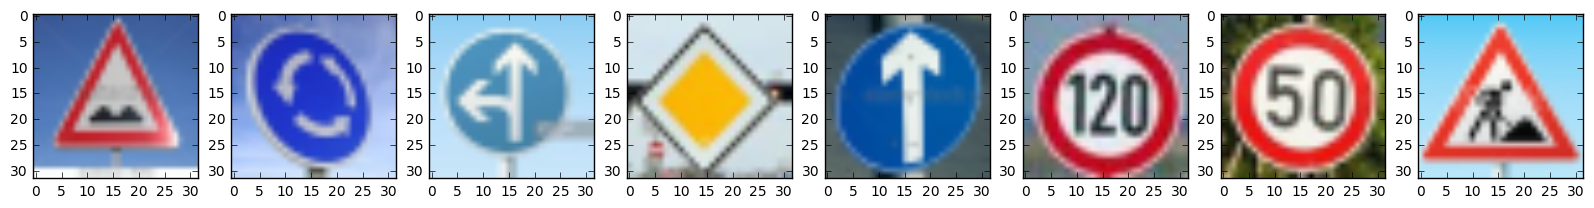

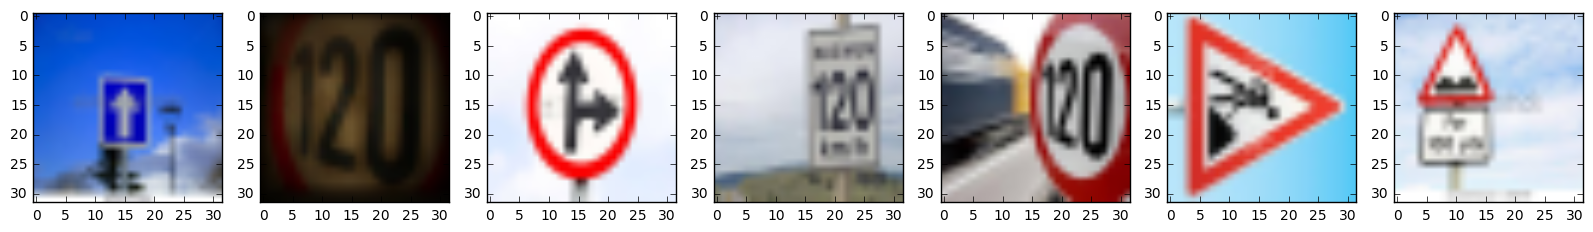

In [90]:
### New images from web
import sys
import matplotlib.image as mpimg

test_files = os.listdir('test_images/')
improper_images = os.listdir('Improper images/')

color_Images = np.zeros(shape=(len(test_files),32,32,3), dtype="float32")

imp_color_Images = np.zeros(shape=(len(improper_images),32,32,3), dtype="float32")

n = 0
for file in test_files:
    img = cv2.imread('test_images/'+file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(32,32),interpolation = cv2.INTER_AREA)
    color_Images[n]=img
    n+=1
    
n = 0
for files in improper_images:
    img = cv2.imread('Improper images/'+files)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(32,32),interpolation = cv2.INTER_AREA)
    imp_color_Images[n]=img
    n+=1
    
clr_Images = color_Images/255
imp_clr_Images = imp_color_Images/255

fig2 = plt.figure (figsize = (20,4))

n = 0
for img in clr_Images:
    im = fig2.add_subplot(1,8,n+1)
    im.imshow(img)
    n+=1
plt.show()

fig3 = plt.figure (figsize = (20,4))

n = 0
for img in imp_clr_Images:
    im = fig3.add_subplot(1,7,n+1)
    im.imshow(img)
    n+=1
plt.show()

color_Images = normalize(color_Images)
imp_color_Images = normalize(imp_color_Images)

correct_labels = [22, 40, 37, 12, 35, 8, 2, 25]
imp_img_labels = [35, 8, 36, 8, 8, 25, 22]

labels_one_hot_encod = np.zeros(shape = (len(correct_labels),43), dtype = 'float32')
imp_labels_one_hot_encod = np.zeros(shape = (len(imp_img_labels),43), dtype = 'float32')

n = 0
for i in correct_labels:
    labels_one_hot_encod[n][i] = 1
    n+=1
    
n = 0
for i in imp_img_labels:
    imp_labels_one_hot_encod[n][i] = 1
    n+=1


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

I chose 8 images downloaded from Internet. One of the images is rotated and other is color changed. The classifier is able to detect the image which is color changed but the rotated image is not detected well.

In [91]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

prob = tf.nn.softmax(logits)
pred_labels = tf.argmax(prob, 1)
#sess = tf.Session()
#sess.run(init)
s = sess.run(pred_labels, feed_dict = {x: color_Images, keep_prob: 1.0})
p = sess.run(pred_labels, feed_dict = {x: imp_color_Images, keep_prob: 1.0})
print(s)
print(p)
print("Test Image Accuracy:",sess.run(accuracy,feed_dict = {x: color_Images, y: labels_one_hot_encod, keep_prob: 1.0}))
print("Improper Test Image Accuracy:",sess.run(accuracy,feed_dict = {x: imp_color_Images, y: imp_labels_one_hot_encod, keep_prob: 1.0}))


[28 40 37 12 35  8  2 25]
[35 12  1  1 11 17 17]
Test Image Accuracy: 0.875
Improper Test Image Accuracy: 0.142857


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

1. Yes, the classifier performed equally well with the first set of images (which are proper and in the training set images) 87.5% when compared to 92.8% of test accuracy. Even the images which is not predicted well has its label in top 5 with a probability of 2.9e-4
2. Second set of Images are skewed, less brightened, out of the training data images and small traffic sign in an image. The accuracy is 1/7. With this set, we can say that the classifier cannot recognise the images which has other images in the scene (Image 7). If the image is tracked well and captured that can be classified and the image should be within the training set.

In [93]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
prob = tf.nn.softmax(logits)

max_prob = tf.nn.top_k(prob, k = 5)

softmax = sess.run(max_prob, feed_dict = {x: color_Images, keep_prob: 1.0})
print(softmax)
imp_softmax = sess.run(max_prob, feed_dict = {x: imp_color_Images, keep_prob: 1.0})
print(imp_softmax)

TopKV2(values=array([[  7.01951742e-01,   2.97497571e-01,   2.94520083e-04,
          2.24901029e-04,   3.11477270e-05],
       [  1.00000000e+00,   1.52196972e-12,   1.45425566e-12,
          1.36108540e-12,   6.25632196e-13],
       [  9.99609172e-01,   3.53417796e-04,   2.18221958e-05,
          1.50116257e-05,   2.40592357e-07],
       [  1.00000000e+00,   1.25135452e-25,   1.77995108e-26,
          5.27277817e-34,   1.48720354e-35],
       [  1.00000000e+00,   2.02080526e-13,   1.04092345e-14,
          9.76404577e-20,   3.89061622e-20],
       [  9.99999166e-01,   7.29003773e-07,   9.64715881e-08,
          1.37698446e-11,   1.32353356e-11],
       [  9.99984503e-01,   1.54642312e-05,   1.01173332e-15,
          4.02402880e-16,   1.12585245e-17],
       [  1.00000000e+00,   1.80136694e-13,   4.57407756e-22,
          3.24879426e-22,   4.42234982e-23]], dtype=float32), indices=array([[28, 29, 22, 23, 17],
       [40, 16, 11,  1, 18],
       [37, 35,  4,  0,  1],
       [12, 14, 17

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:** 

1. For the first set of images, the classifier did a pretty good job in identifying the images. 7 out of 8 are correct. With top_k the wrong predicted labels has the correct label in top 5 with a probability of 2.9e-4
2. For the second set of images, other than one image which is detected correctly, remaining labels are not in top 5 probabilities. This clearly shows that my classifier can perform only in Germany in a well lit area, with the straight boards and when the camera focuses perfectly on the image.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In [82]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

#csvfile = open('./signnames.csv')
#reader = csv.DictReader(csvfile,  delimiter = ",")
#for n in s:
#    for row in reader:
#        if (int(row['ClassId']) == n):
#            print (row['SignName'])
#            break
#prob = tf.nn.softmax(logits)

#pred_labels = tf.argmax(prob, 1)

#sess.run(pred_labels, feed_dict = {x: test, keep_prob: 1.0})

#print(pr)